In [1]:
import math
import pandas as pd
import numpy as np
from mesa import Agent
import random

In [2]:
class Pupil(Agent):
    
    """
    Define the agent type: pupils
        they have location information and travel behaviours;
        They will carry out some functions: choose destination, choose mode, etc
        
        Attributes:
            unique_id : the id of the agent
            hx,hy: the home location of the agent's home
            school: the agent's destination school
            # road_p: road choice probability distribution, e.g. road_p = [0.3,0.3,0.3,0.1]
            mode_p: mode choice probability distribution, e.g. mode_p = [0.1,0.9,0,0]
            perception: the agent's perception towards the COVID-19, from 1-5 , the perception increases
            health: agent's health condition, "s","i","r" representing the susecptibel, exposed, infected, reovered
    
    """
    
    def __init__(self,
                unique_id,
                model,
                hx,
                hy,
                school,  # road_p is deleted here
                mode_p,
                perception,
                health):
        ## define a new agent
        
        super().__init__(unique_id,model)
        self.breed = 'pupil' # define the agent type: pupil
        self.hx = hx
        self.hy = hy
        self.school = school
        #self.road_p = road_p
        self.mode_p = mode_p
        self.perception = perception
        self.health = health
        self.infection_time = 0  ## record the infection time
        self.time = 0
        
        
        ## define the mode choice and corresponding risk, simple version by considering the whole commute process as a discrete event
        self.modes = ['bus','school bus','private car','walk']
        # mode_risk = {'bus':0.03,'school bus':0.01,'private car':0.001,'walk':0.02}
        self.roads = {'bus':[7],'school bus':[6],'private car':[4,5],'walk':[1,2,3]}
        self.road_risk = {1:0.005,2:0.004,3:0.002,4:0.004,5:0.005,6:0.01,7:0.003}
        self.road_cell = {1:(50,1),2:(50,2),3:(50,3),4:(50,4),5:(50,5),6:(50,6),7:(50,7)}
        
        
        
        

        
           
        
    def infect(self):
        """Find close contacts and infect"""

        cellmates = self.model.grid.get_cell_list_contents([self.pos])       
        if len(cellmates) > 1:
            for other in cellmates:
                if (self.random.random() < 0.5*((6-self.perception)/5)*((6-other.perception)/5)) and other.health =='s':                    
                    other.health = 'i'
                    other.infection_time = self.model.schedule.time
                    
                    
            
    

        
        
    def test(self):
        
        schools = {1:(15,15),2:(30,30)}
        self.model.grid.move_agent(self,schools[self.school])
        if self.health == 'i':
            self.infect()
        
        self.model.grid.move_agent(self,(self.hx,self.hy))
        
    
    def step1(self):
        ## move to the assigned road from home
        mode = np.random.choice(self.modes,size=None,p=self.mode_p)
            
        # assign the road
        road = np.random.choice(self.roads[mode])
        #self.model.grid.move_agent(self,road_cell[road])    
        # calculate the travel risk = risk * perception
            
        risk = self.road_risk[road] * (6-self.perception)
        self.model.grid.move_agent(self,self.road_cell[road])
        
        ## if agent is susceptibel, it is possible to be infected 
        if self.health == 's':
            if random.random()<risk:
                self.health = 'i'
                self.infection_time = self.model.schedule.time
        
        
        # if it is infected, calculate whether it is recovered
        ## if agent is infected, it is possible to infect other agents.   
        if self.health == 'i':
            t = self.model.schedule.time-self.infection_time
            if t >= 21:          
                self.health = 'r'
            else:
                self.infect()
    
    def step2(self):
        
        ## move to school from the road
        
        schools = {1:(15,15),2:(30,30)}
        self.model.grid.move_agent(self,schools[self.school])
        if self.health == 'i':
            self.infect()
            
    def step3(self):
        
        # move to the home from the road
        
        self.model.grid.move_agent(self,(self.hx,self.hy))
        if self.health == 'i':
                t = self.model.schedule.time-self.infection_time
                if t >= 21:          
                    self.health = 'r'
                else:
                    self.infect()
        
        
        
        

    def step(self):
    
        
        """
        This step function will tell agents their agenda for one day
        
        First, detect if the agent is infected, this is for destination choosing;
        
        Then, choose the mode for this destination;
        
        The movement will happen by move function, and the process will include the transmission or infection
        
        Once arrive the destination, the agent will stay there and have another possible transmission or infection
      
        """
        self.time = self.time+1
        
        if self.time % 4 == 1:
            self.step1()
        if self.time % 4 == 2:
            self.step2()
        if self.time % 4 == 3:
            self.step1()
        if self.time % 4 == 4:
            self.step3()
        
        
        
        #self.assign_road()
        #self.school_activity()
        #self.go_home()
        #self.test()
   
    
    
            
            
            
        
    
        

In [3]:
class Household(Agent):
    """
    
    Now define the agnet type: Household members
    
    work: whether they need to go to the workplace, 0:stay home; 1:go outside
    
    hx,hy: house location
    
    workplace: if they need to go to the work place,there are 1,2,3 different workplaces
    
    mode_p: the mode choice probablility distribution, as Pupil
    
    perception: the covid-19 perception, from 1-5
    
    """
    def __init__(self, unique_id, model,hx, hy, work, workplace, mode_p, perception, health):
        
        super().__init__(unique_id,model)
        self.breed = 'household'
        self.work = work
        self.hx = hx
        self.hy = hy
        self.workplace =  workplace
        self.mode_p = mode_p
        self.perception = perception
        self.health = health
        
        self.infection_time = 0  ## record the infection time
        self.time = 0
        
        
        ## define the mode choice and corresponding risk, simple version by considering the whole commute process as a discrete event
        self.modes = ['bus','private car','walk']
        # mode_risk = {'bus':0.03,'school bus':0.01,'private car':0.001,'walk':0.02}
        self.roads = {'bus':[6,7,8,9],'private car':[4,5],'walk':[1,2,3]}
        self.road_risk = {1:0.005,2:0.004,3:0.002,4:0.004,5:0.005,6:0.01,7:0.003,8:0.002,9:0.001}
        self.road_cell = {1:(49,1),2:(49,2),3:(49,3),4:(49,4),5:(49,5),6:(49,6),7:(49,7),8:(49,8),9:(49,9)}
    
    def infect(self):
        """Find close contacts and infect"""

        cellmates = self.model.grid.get_cell_list_contents([self.pos])       
        if len(cellmates) > 1:
            for other in cellmates:
                if (self.random.random() < 0.5*((6-self.perception)/5)*((6-other.perception)/5)) and other.health =='s':                    
                    other.health = 'i'
                    other.infection_time = self.model.schedule.time
                    
    
    def step1(self):
        if self.work == 1:
            ## move to the assigned road from home
            mode = np.random.choice(self.modes,size=None,p=self.mode_p)
            
            # assign the road
            road = np.random.choice(self.roads[mode])
            #self.model.grid.move_agent(self,road_cell[road])    
            # calculate the travel risk = risk * perception
            
            risk = self.road_risk[road] * (6-self.perception)
            self.model.grid.move_agent(self,self.road_cell[road])
        
            ## if agent is susceptibel, it is possible to be infected 
            if self.health == 's':
                if random.random()<risk:
                    self.health = 'i'
                    self.infection_time = self.model.schedule.time
        
        
            # if it is infected, calculate whether it is recovered
            ## if agent is infected, it is possible to infect other agents.   
            if self.health == 'i':
                self.infect()
    
    def step2(self):
        
        ## move to workplaces from the road, if they are healthy, they may be infected by the environment.
        
        workplaces = {1:(15,15),2:(30,30),3:(45,45)}
        if self.work == 1:
            self.model.grid.move_agent(self,workplaces[self.workplace])
            if self.health == 'i':
                self.infect()
                
            if self.health == 's':
                risk = 0.002*(6-self.perception)
                if random.random() < risk:
                    self.health = 'i'
                    self.infection_time = self.model.schedule.time
            
    def step3(self):
        
        # move to the home from the road
        
        self.model.grid.move_agent(self,(self.hx,self.hy))
        if self.health == 'i':
                t = self.model.schedule.time-self.infection_time
                if t >= 21:          
                    self.health = 'r'
                else:
                    self.infect()
        
        
        
        

    def step(self):
    
        
        """
        This step function will tell agents their agenda for one day
        
        First, detect if the agent is infected, this is for destination choosing;
        
        Then, choose the mode for this destination;
        
        The movement will happen by move function, and the process will include the transmission or infection
        
        Once arrive the destination, the agent will stay there and have another possible transmission or infection
      
        """
        self.time = self.time+1
        
        if self.time % 4 == 1:
            self.step1()
        if self.time % 4 == 2:
            self.step2()
        if self.time % 4 == 3:
            self.step1()
        if self.time % 4 == 4:
            self.step3()
        
        
        
        
        
        
        
        

In [4]:
from mesa import Model
from mesa.datacollection import DataCollector
from mesa.time import SimultaneousActivation
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector


def total_inf(model):
    total_infection = 0
    for agent in model.schedule.agents:
        if agent.health == 'i':
            total_infection += 1
    return total_infection

def pupil_inf(model):
    pupil_infection = 0
    for agent in model.schedule.agents:
        if agent.health == 'i' and agent.breed == 'pupil':
            pupil_infection += 1
        return pupil_infection

def household_inf(model):
    household_inf = 0
    for agent in model.schedule.agents:
        if agent.health == 'i' and agent.breed == 'household':
            household_inf += 1
    return household_inf

def home_inf(model):
    home_inf = 0
    for agent in model.schedule.agents:
        if agent.health == 'i' and agent.pos == (agent.hx, agent.hy):
            home_inf += 1
    return home_inf

def school_inf(model):
    school_inf = 0
    schools = {1: (15, 15), 2: (30, 30)}
    for agent in model.schedule.agents:
        if agent.breed == 'pupil':
            if agent.health == 'i' and agent.pos == schools[agent.school]:
                school_inf += 1
    return school_inf

def workplace_inf(model):
    workplace_inf = 0
    workplaces = {1: (15, 15), 2: (30, 30), 3: (45, 45)}
    for agent in model.schedule.agents:
        if agent.breed == 'household':
            if agent.health == 'i' and agent.pos == workplaces[agent.workplace]:
                workplace_inf += 1
    return workplace_inf

def road_inf(model):
    road_inf = 0
    road_inf = total_inf(model) - home_inf(model) - workplace_inf(model) - school_inf(model)
    return road_inf    


class SimModel(Model):
    
    """
    The model will give a basic enviornment paramter configuration.
    And generate the grid, agents.
    """
    
    def __init__(self,
                height = 51,
                width = 51,
                
                ):
        super().__init__()
        self.height = height
        self.width = width
        self.grid = MultiGrid(height,width,torus=False)
        
        self.iteration = 0
    
    
        self.schedule = SimultaneousActivation(self)
        
        # collect the data
        model_reporters = {
            "Total_infection": total_inf,
            "Pupil infection": pupil_inf,
            "Household Infection": household_inf,
            "Home infection": home_inf,
            "School infection": school_inf,
            "Workplace infection": workplace_inf,
            "Road infection": road_inf
        }
        
        self.datacollector = DataCollector(model_reporters=model_reporters,agent_reporters=None)
    
    
        # generate the agents from the file
        AgentParaDataFrame = pd.read_csv('pupil.csv')
        for row in range(0, AgentParaDataFrame.shape[0]):
            agent = Pupil(
                AgentParaDataFrame.iloc[row][0],
                self,
                AgentParaDataFrame.iloc[row][2],
                AgentParaDataFrame.iloc[row][3],
                AgentParaDataFrame.iloc[row][4],
                (AgentParaDataFrame.iloc[row][5],AgentParaDataFrame.iloc[row][6],AgentParaDataFrame.iloc[row][7],AgentParaDataFrame.iloc[row][8]),
                AgentParaDataFrame.iloc[row][9],
                AgentParaDataFrame.iloc[row][10]
                )
            self.schedule.add(agent)
            self.grid.place_agent(agent,(agent.hx,agent.hy))
            #self.running = True
            
         
        HouseholdPara = pd.read_csv('household.csv')
        for row in range(0,HouseholdPara.shape[0]):
            agent = Household(
                HouseholdPara.iloc[row][0]+20,
                self,
                HouseholdPara.iloc[row][2],
                HouseholdPara.iloc[row][3],
                HouseholdPara.iloc[row][4],
                HouseholdPara.iloc[row][5],
                (HouseholdPara.iloc[row][6],HouseholdPara.iloc[row][7],HouseholdPara.iloc[row][8]),
                HouseholdPara.iloc[row][9],
                HouseholdPara.iloc[row][10]
                )
            self.schedule.add(agent)
            self.grid.place_agent(agent,(agent.hx,agent.hy))
    
        
        
        self.running = True
    
    def step(self):
        
        #if self.schedule.time % 4 == 0:
        self.datacollector.collect(self)
        self.schedule.step()
        
        
    

In [5]:
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import ChartModule
import nest_asyncio
nest_asyncio.apply()


def agent_portrayal(agent):
    
    
    portrayal = {"Shape":"circle",
                 "Filled": "true",
                 "Layer":0,
                 "r":0.7}
    
   
    if agent.health == 's':
        portrayal['Color'] = 'green'
    if agent.health == 'i':
        portrayal['Color'] = 'red'
    if agent.health == 'r':
        portrayal['Color'] = 'gray'
    
    
  
    return portrayal


grid = CanvasGrid(agent_portrayal, 52, 52, 500,500)


chart = ChartModule(
    [
        {"Label":"Total_infection","Color":"red"},
        {"Label":"Pupil infection","Color":"green"},
        {"Label":"Household Infection","Color":"yellow"},
        {"Label":"Home infection","Color":"blue"},
        {"Label":"School infection","Color":"grey"},
        {"Label":"Workplace infection","Color":"black"},
        {"Label":"Road infection","Color":"orange"}
    ]
    )

server = ModularServer(SimModel,
                       [grid,chart],
                       "Commute & Epidemic",
                       { "width":52, "height":52})
server.port = 8850 # The default
server.launch()

Interface starting at http://127.0.0.1:8850
Socket opened!
{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}


KeyboardInterrupt: 

In [6]:
model = SimModel(51,51)
for i in range(30):
    model.step()

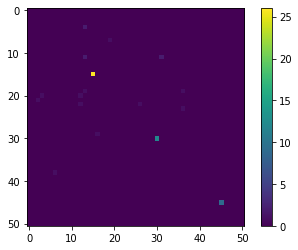

In [7]:
import numpy as np
import matplotlib.pyplot as plt
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()


In [ ]:
## add animation, server
## adjust the order

In [8]:
model.datacollector.get_model_vars_dataframe()

,Total_infection,Pupil infection,Household Infection,Home infection,School infection,Workplace infection,Road infection
0,1,0,0,1,0,0,0
1,2,0,0,0,0,0,2
2,4,0,0,0,4,0,0
3,6,0,1,0,0,0,6
4,6,0,1,0,0,0,6
5,17,0,12,0,0,0,17
6,35,1,19,0,16,19,0
7,38,1,22,0,0,0,38
8,38,1,22,0,0,0,38
9,40,1,22,0,0,0,40
